<a href="https://colab.research.google.com/github/Raman-Raje/colab_notebooks/blob/master/article_segmentation_vgg_segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### About Dataset

* 101 images for each image and annotation class are present

* There are three classes: text area, picture area, background
* 1 ==> Pixels on the mask with color 255, 0, 0 (rgb, red color) correspond to picture area.
* 2 ==> pixels with color 0, 0, 255 (rgb, blue color) correspond to text area.
* 0 ==> all other pixels correspond to background.

In [1]:
# get the datset 
! wget --no-check-certificate https://archive.ics.uci.edu/ml/machine-learning-databases/00306/dataset_segmentation.rar 

--2020-04-02 03:51:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/00306/dataset_segmentation.rar
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 410202288 (391M) [application/x-httpd-php]
Saving to: ‘dataset_segmentation.rar’

dataset_segmentatio 100%[===================>] 391.20M  95.9MB/s    in 4.2s    

2020-04-02 03:51:59 (92.1 MB/s) - ‘dataset_segmentation.rar’ saved [410202288/410202288]



In [2]:
! pip install patool
import patoolib
patoolib.extract_archive("/content/dataset_segmentation.rar", outdir="./")

     |████████████████████████████████| 81kB 3.8MB/s 
patool: Extracting /content/dataset_segmentation.rar ...
patool: running /usr/bin/unrar x -- /content/dataset_segmentation.rar
patool:     with cwd='./'
patool: ... /content/dataset_segmentation.rar extracted to `./'.


'./'

In [3]:
! pip install keras_segmentation

     |████████████████████████████████| 3.3MB 48kB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-cp36-none-any.whl size=29072 sha256=84e91929848c70ddf0a1fef94a4b869c0a989352000c3dacbc9442df18bb3748
  Stored in directory: /root/.cache/pip/wheels/d0/bb/c0/6aad88b38f6e46db048bed4cccb904a5897055a8ab6fbd4dfc
Successfully built keras-segmentation
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1


In [4]:
%tensorflow_version 1.x
import os
import cv2
import shutil
import random 

import numpy as np
import pandas as pd
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

from keras_segmentation.models.segnet import vgg_segnet,segnet
from keras_segmentation.predict import predict_multiple,predict

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
rootdir = "./content/dataset_segmentation"
pre_dataset = "./content/dataset/"
height = 320
width = 256

In [0]:
if not os.path.exists(pre_dataset):
        os.makedirs(pre_dataset)

directory = ["./content/data/train/annotations/","./content/data/test/annotations/",
             "./content/data/train/images/","./content/data/test/images/",
             "./content/data/val/annotations/","./content/data/val/images/",
             "./content/data/images/","./content/data/annotations/","/content/content/checkpoints/vgg_segnet"
             ]
for ed in directory:
    if not os.path.exists(ed):
        os.makedirs(ed)

In [0]:
os.remove("/content/dataset_segmentation/documentation.txt")

In [8]:
# resizing the image
for subdir, dirs, files in os.walk("/content/dataset_segmentation/"):
    for i,file in enumerate(files):
        path = subdir+file
        print(i,path)
        img = cv2.imread(path)
        img_ = cv2.resize(img,(width,height),interpolation=cv2.INTER_AREA)
        file = file.replace(file.split(".")[-1],"png")
        path_ = pre_dataset + file
        cv2.imwrite(path_,img_)


0 /content/dataset_segmentation/75.jpg
1 /content/dataset_segmentation/68.jpg
2 /content/dataset_segmentation/9_m.png
3 /content/dataset_segmentation/9.jpg
4 /content/dataset_segmentation/11_m.png
5 /content/dataset_segmentation/1s.bmp
6 /content/dataset_segmentation/48_m.png
7 /content/dataset_segmentation/45.jpg
8 /content/dataset_segmentation/69.jpg
9 /content/dataset_segmentation/31_m.png
10 /content/dataset_segmentation/4_m.png
11 /content/dataset_segmentation/34.jpg
12 /content/dataset_segmentation/6.jpg
13 /content/dataset_segmentation/38_m.png
14 /content/dataset_segmentation/23.jpg
15 /content/dataset_segmentation/73.jpg
16 /content/dataset_segmentation/52.jpg
17 /content/dataset_segmentation/49.jpg
18 /content/dataset_segmentation/47.jpg
19 /content/dataset_segmentation/65_m.png
20 /content/dataset_segmentation/68_m.png
21 /content/dataset_segmentation/8.jpg
22 /content/dataset_segmentation/40_m.png
23 /content/dataset_segmentation/51.jpg
24 /content/dataset_segmentation/22.j

In [0]:
for filename in os.listdir("/content/content/dataset"):
    if "_m" in filename:
        shutil.move("/content/content/dataset/"+filename,"/content/content/data/annotations/"+filename)
    else:
        shutil.move("/content/content/dataset/"+filename,"/content/content/data/images/"+filename)
        
 

In [0]:
def annoted_image(img):
    img_ = np.zeros(img.shape).astype('uint8')

    #Isolate the areas where the color is 255(in first channel) and 255 (in last channel)
    picture_area =np.where((img[:,:,0]==255))
    text_area = np.where((img[:,:,2] == 255))

    # create a new image with the same shape and replace correspoding pixels as per classes
    img_[picture_area] = 1
    img_[text_area] = 2
    
    # return the annotated image
    return img_

In [11]:
for subdir, dirs, files in os.walk("/content/content/data/annotations"):
    for ef in files:
        path = "/content/content/data/annotations/" + ef
        print(path)
        img = cv2.imread(path)
        img_ = annoted_image(img)
        cv2.imwrite(path,img_)
        os.rename(path,path.replace("_m",""))

/content/content/data/annotations/5s_m.png
/content/content/data/annotations/4m_m.png
/content/content/data/annotations/9_m.png
/content/content/data/annotations/4g_m.png
/content/content/data/annotations/11_m.png
/content/content/data/annotations/3s_m.png
/content/content/data/annotations/48_m.png
/content/content/data/annotations/31_m.png
/content/content/data/annotations/4_m.png
/content/content/data/annotations/38_m.png
/content/content/data/annotations/2s_m.png
/content/content/data/annotations/65_m.png
/content/content/data/annotations/3cw_m.png
/content/content/data/annotations/68_m.png
/content/content/data/annotations/40_m.png
/content/content/data/annotations/1m_m.png
/content/content/data/annotations/46_m.png
/content/content/data/annotations/6s_m.png
/content/content/data/annotations/60_m.png
/content/content/data/annotations/56_m.png
/content/content/data/annotations/32_m.png
/content/content/data/annotations/10_m.png
/content/content/data/annotations/61_m.png
/content/con

In [12]:
# train and test data seperation for both images and annotations
test = random.sample(range(101),30)
val = random.sample(test,15)

test = [x for x in test if x not in val]

print(test)
print(val)

[5, 33, 65, 51, 61, 27, 79, 77, 18, 83, 9, 42, 60, 71, 76]
[74, 64, 45, 32, 68, 62, 12, 36, 17, 86, 38, 97, 39, 49, 53]


In [0]:


for subdir, dirs, files in os.walk("/content/content/data/annotations/"):
    for i,file in enumerate(files):
        path = subdir + file
        path_ = "/content/content/data/images/"+file
        if i in test:
            shutil.move(path,"/content/content/data/test/annotations/"+file)
            shutil.move(path_,"/content/content/data/test/images/"+file)
        elif i in val:
            shutil.move(path,"/content/content/data/val/annotations/"+file)
            shutil.move(path_,"/content/content/data/val/images/"+file)
        else:
            shutil.move(path,"/content/content/data/train/annotations/"+file)
            shutil.move(path_,"/content/content/data/train/images/"+file)

### Model Building

In [14]:
vgg_seg = vgg_segnet(n_classes=3,input_height=height,input_width=width)





58892288/58889256 [==============================] - 2s 0us/step











In [16]:
vgg_seg.train( 
    train_images =  "/content/content/data/train/images/",
    train_annotations = "/content/content/data/train/annotations/",
    checkpoints_path = "/content/content/checkpoints/vgg_segnet" , 
    val_images ="/content/content/data/val/images/",
    val_annotations = "/content/content/data/val/annotations/",
    epochs=15
)

 44%|████▎     | 31/71 [00:00<00:00, 305.08it/s]

Verifying training dataset


100%|██████████| 71/71 [00:00<00:00, 310.03it/s]


Dataset verified! 
Epoch 1/15
512/512 [==============================] - 27s 53ms/step - loss: 0.6794 - acc: 0.7069
saved  /content/content/checkpoints/vgg_segnet.0
Epoch 2/15
512/512 [==============================] - 26s 50ms/step - loss: 0.5339 - acc: 0.7816
saved  /content/content/checkpoints/vgg_segnet.1
Epoch 3/15
512/512 [==============================] - 25s 50ms/step - loss: 0.4204 - acc: 0.8390
saved  /content/content/checkpoints/vgg_segnet.2
Epoch 4/15
512/512 [==============================] - 25s 50ms/step - loss: 0.3183 - acc: 0.8833
saved  /content/content/checkpoints/vgg_segnet.3
Epoch 5/15
512/512 [==============================] - 25s 49ms/step - loss: 0.2563 - acc: 0.9073
saved  /content/content/checkpoints/vgg_segnet.4
Epoch 6/15
512/512 [==============================] - 25s 49ms/step - loss: 0.2131 - acc: 0.9223
saved  /content/content/checkpoints/vgg_segnet.5
Epoch 7/15
512/512 [==============================] - 25s 50ms/step - loss: 0.1793 - acc: 0.9341
saved  /

In [17]:
# evaluating the model 
print(vgg_seg.evaluate_segmentation( inp_images_dir="/content/content/data/test/images/" , annotations_dir="/content/content/data/test/annotations/" ) )

15it [00:00, 23.19it/s]

{'frequency_weighted_IU': 0.7492588672268599, 'mean_IU': 0.7320025112641176, 'class_wise_IU': array([0.62410063, 0.82907891, 0.74282799])}


### Inferance Code

In [0]:
def get_image(img,threshold = 160):

    img_ = np.zeros(img.shape).astype('uint8')

    #Isolate the areas where the color is 255(in first channel) and 255 (in last channel)
    picture_area =np.where((img[:,:,0]>=threshold))
    text_area = np.where((img[:,:,2]>= threshold))

    # create a new image with the same shape and replace correspoding pixels as per classes
    img_[picture_area] = 255
    img_[text_area] = 255
    
    # return the annotated image
    return img_

def segment_image(output,original,contours_cnt = 20,threshold = 190):
   
    out_ = get_image(output,threshold=threshold)
    
    img = cv2.GaussianBlur(out_,(5,5),0)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    the = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

    # Find contours 
    contours, hierarchy = cv2.findContours(the.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    # Sort Contors by area and then remove the largest frame contour
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contours = contours[:contours_cnt]
    
        # Iterate through each contour and compute the bounding rectangle
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(original,(x,y),(x+w,y+h),(0,0,255),2)    
        
    return original


### Lets Predict on Some Examples

#### Ex. 1

In [0]:
test_image = "/content/content/data/test/images/2cw.png"
output_img = "/content/dataset_segmentation/2cw_m.bmp"
output_path = "/content/out.png"

In [0]:
out = vgg_seg.predict_segmentation(inp=test_image,out_fname="out.png")

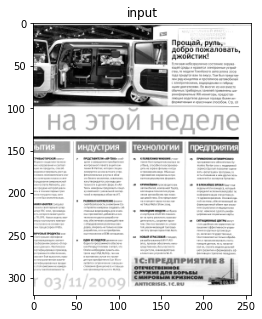

In [0]:
# input image
plt.figure(figsize=(10,5))
inp = cv2.imread(test_image)
plt.title("input")
plt.imshow(inp)

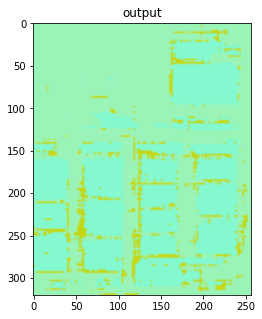

In [0]:
# output image
plt.figure(figsize=(10,5))
out = cv2.imread("/content/out.png")
plt.title("output")
plt.imshow(out)

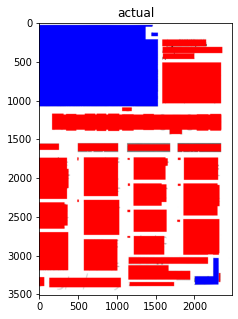

In [0]:
# actual image
plt.figure(figsize=(10,5))
actual = cv2.imread(output_img)
plt.title("actual")
plt.imshow(actual)

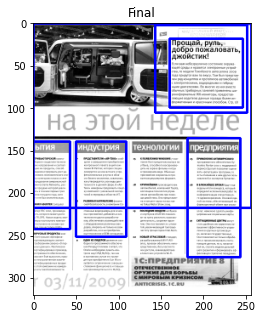

In [0]:
original = cv2.imread(test_image)
output = cv2.imread(output_path)

result = segment_image(output,original,contours_cnt=6,threshold=185)

# actual image
plt.figure(figsize=(10,5))
plt.title("Final")
plt.imshow(result)

#### Example - 2

In [0]:
test_image = "/content/content/data/test/images/57.png"
actual_img = "/content/dataset_segmentation/57_m.png"

In [0]:
  out = vgg_seg.predict_segmentation(
    inp=test_image,
    out_fname="out.png")

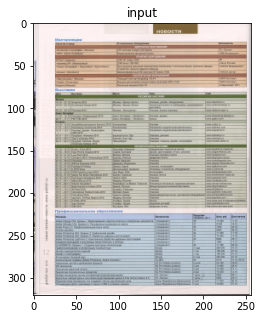

In [0]:
# input image
plt.figure(figsize=(10,5))
inp = cv2.imread(test_image)
plt.title("input")
plt.imshow(inp)

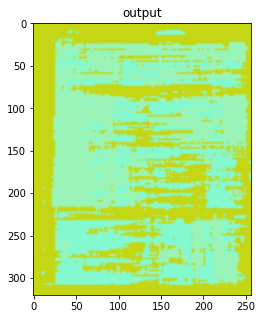

In [0]:
# output image
plt.figure(figsize=(10,5))
out = cv2.imread("/content/out.png")
plt.title("output")
plt.imshow(out)

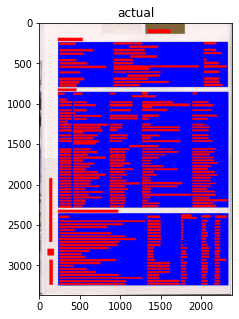

In [0]:
# actual image
plt.figure(figsize=(10,5))
actual = cv2.imread(actual_img)
plt.title("actual")
plt.imshow(actual)

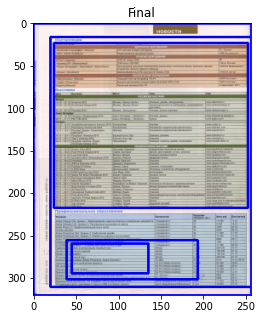

In [0]:
original = cv2.imread(test_image)
output = cv2.imread(output_path)

result = segment_image(output,original,contours_cnt=5,threshold=180)

# actual image
plt.figure(figsize=(10,5))
plt.title("Final")
plt.imshow(result)

#### Example - 3

In [0]:
test_image = "/content/content/data/test/images/61.png"
actual_img = "/content/dataset_segmentation/61_m.png"

In [0]:
  out = vgg_seg.predict_segmentation(
    inp=test_image,
    out_fname="out.png")

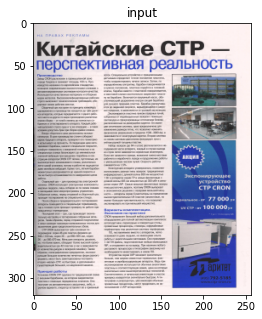

In [0]:
# input image
plt.figure(figsize=(10,5))
inp = cv2.imread(test_image)
plt.title("input")
plt.imshow(inp)

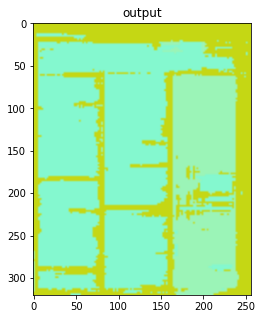

In [0]:
# output image
plt.figure(figsize=(10,5))
out = cv2.imread("/content/out.png")
plt.title("output")
plt.imshow(out)

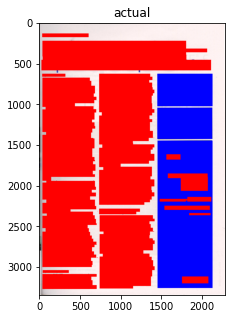

In [0]:
# actual image
plt.figure(figsize=(10,5))
actual = cv2.imread(actual_img)
plt.title("actual")
plt.imshow(actual)

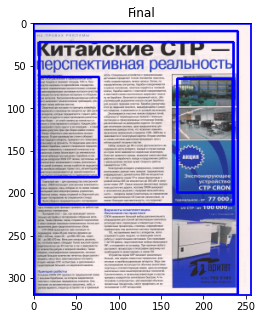

In [0]:
original = cv2.imread(test_image)
output = cv2.imread(output_path)

result = segment_image(output,original,contours_cnt=,threshold=185)

# actual image
plt.figure(figsize=(10,5))
plt.title("Final")
plt.imshow(result)